In [ ]:
from IPython.display import clear_output

!pip install -U "ray[rllib]"
!pip install tianshou
!pip install "stable-baselines3[extra]>=2.0.0a4"
!pip install mat4py

clear_output()

# LIBPackEnv

d:\Users\amirh\anaconda3\lib\site-packages\gymnasium\spaces\box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


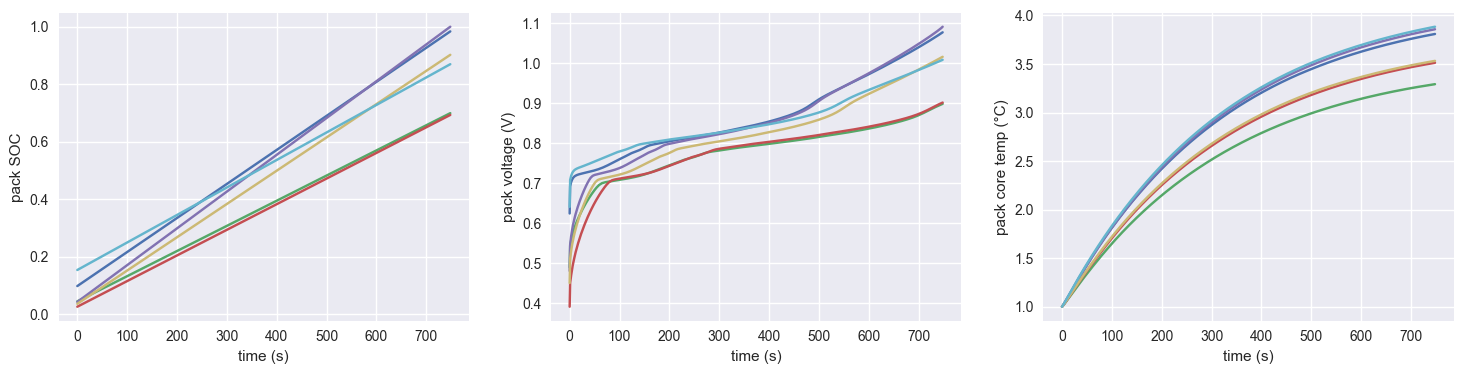

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from LIBEnv.LIB_gym_delta import LIBPackEnv
plt.style.use('seaborn-v0_8') # seaborn-v0_8

env = LIBPackEnv('./LIBEnv/PANmodel.mat', number_of_cells=6, T=25, dt=1)

pack_res=[]
rewards = []
pack_res.append(env.reset()[0].reshape(3,6))
done = False
while not done:
    next_state, reward, done, _, info = env.step(np.ones(7))
    pack_res.append(next_state.reshape(3,6))
    rewards.append(reward)

pack_res = np.array(pack_res)
plt.figure(figsize=(18,4))
plt.subplot(1,3,1)
plt.plot(pack_res[:,0,:])
plt.xlabel('time (s)')
plt.ylabel('pack SOC')
plt.grid('on')
plt.subplot(1,3,2)
plt.plot(pack_res[:,1,:])
plt.xlabel('time (s)')
plt.ylabel('pack voltage (V)')
plt.grid('on')
plt.subplot(1,3,3)
plt.plot(pack_res[:,2,:])
plt.xlabel('time (s)')
plt.ylabel('pack core temp (°C)')
plt.grid('on')

### Tensorboard 

In [ ]:
#@title Tensorboard - click the refresh button once training is running

%load_ext tensorboard
%tensorboard --logdir logs

# stable baseline3

In [2]:
from stable_baselines3.common.callbacks import BaseCallback

class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq:
    :param log_dir: Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: Verbosity level: 0 for no output, 1 for info messages, 2 for debug messages
    """
    def __init__(self, check_freq: int, log_dir: str, verbose: int = 1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
       pass
        # Create folder if needed
        # if self.save_path is not None:
        #     os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

          # Retrieve training reward
          x, y = ts2xy(load_results(self.log_dir), "timesteps")
          if len(x) > 0:
              # Mean training reward over the last 100 episodes
              mean_reward = np.mean(y[-100:])
              if self.verbose >= 1:
                print(f"Num timesteps: {self.num_timesteps}")
                print(f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}")

              # New best model, you could save the agent here
              if mean_reward > self.best_mean_reward:
                  self.best_mean_reward = mean_reward
                  # Example for saving best model
                  if self.verbose >= 1:
                    print(f"Saving new best model to {self.save_path}")
                  self.model.save(self.save_path)

        return True

d:\Users\amirh\anaconda3\lib\site-packages\torch\utils\tensorboard\__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(


In [3]:
from stable_baselines3 import PPO, DDPG, A2C, TD3, SAC
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.env_checker import check_env
import os 

timesteps = 1e7
log_dir = "./"

check_env(env, warn=True)
env = Monitor(env, log_dir)
model = SAC("MlpPolicy", env, verbose=1, 
            tensorboard_log="logs", 
            learning_rate=1e-3, 
            buffer_size=int(1e6),
            batch_size=1024,
            gamma=0.95,
            tau=0.05,
            policy_kwargs=dict(net_arch=[512, 512, 512]))

callback = SaveOnBestTrainingRewardCallback(check_freq=2e4, log_dir=log_dir)

# Train the agent
# model = model.load('best_model.zip', env)
model.learn(total_timesteps=timesteps, callback=callback, progress_bar=False)

d:\Users\amirh\anaconda3\lib\site-packages\stable_baselines3\common\env_checker.py:422: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf. https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


Using cuda device
Wrapping the env in a DummyVecEnv.
Logging to logs\SAC_4
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 993       |
|    ep_rew_mean     | -2.35e+04 |
| time/              |           |
|    episodes        | 4         |
|    fps             | 35        |
|    time_elapsed    | 112       |
|    total_timesteps | 3973      |
| train/             |           |
|    actor_loss      | 235       |
|    critic_loss     | 54.1      |
|    ent_coef        | 0.344     |
|    ent_coef_loss   | 1.94      |
|    learning_rate   | 0.001     |
|    n_updates       | 3872      |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 920       |
|    ep_rew_mean     | -2.47e+04 |
| time/              |           |
|    episodes        | 8         |
|    fps             | 34        |
|    time_elapsed    | 214       |
|    total_timesteps | 7362      |
| train/       

KeyboardInterrupt: 

In [4]:
model.actor

Actor(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (latent_pi): Sequential(
    (0): Linear(in_features=18, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
  )
  (mu): Linear(in_features=512, out_features=12, bias=True)
  (log_std): Linear(in_features=512, out_features=12, bias=True)
)

In [5]:
model.critic

ContinuousCritic(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (qf0): Sequential(
    (0): Linear(in_features=30, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=1, bias=True)
  )
  (qf1): Sequential(
    (0): Linear(in_features=30, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=1, bias=True)
  )
)

In [ ]:
model = model.load('./best_model.zip', env)

Wrapping the env in a DummyVecEnv.


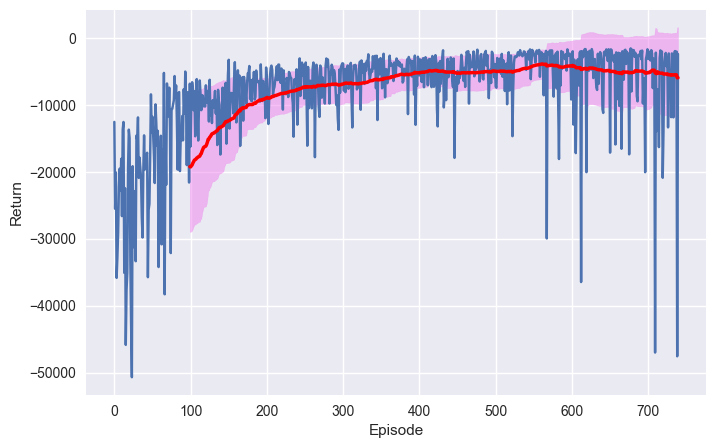

In [4]:
import pandas as pd
results = pd.read_csv('./monitor.csv').reset_index()
results.columns = [results.iloc[0]]
results.drop([0], inplace=True)
returns = np.array(results['r'].astype(float)).ravel()

window = 100
rolling_mean = pd.Series(returns).rolling(window).mean()
std = pd.Series(returns).rolling(window).std()

plt.figure(figsize=(8,5))
plt.plot(returns)
plt.plot(rolling_mean, color='red', linewidth=2.5)
plt.fill_between(range(len(rolling_mean)),rolling_mean-std, rolling_mean+std, color='violet', alpha=0.5)

plt.xlabel('Episode')
plt.ylabel('Return')
plt.grid('on')

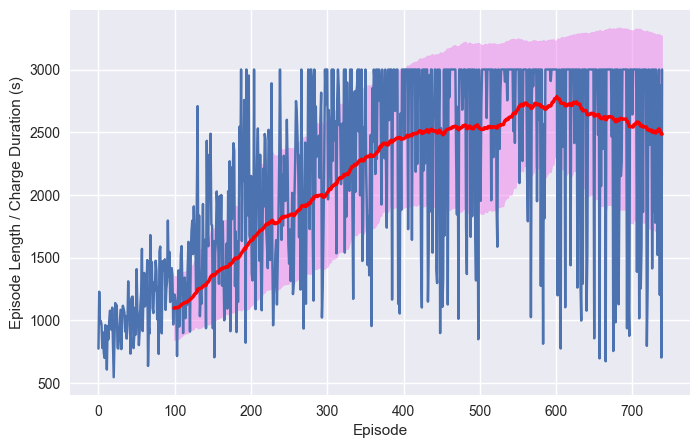

In [5]:
import pandas as pd
results = pd.read_csv('./monitor.csv').reset_index()
results.columns = [results.iloc[0]]
results.drop([0], inplace=True)
returns = np.array(results['l'].astype(float)).ravel()

window = 100
rolling_mean = pd.Series(returns).rolling(window).mean()
std = pd.Series(returns).rolling(window).std()

plt.figure(figsize=(8,5))
plt.plot(returns)
plt.plot(rolling_mean, color='red', linewidth=2.5)
plt.fill_between(range(len(rolling_mean)),rolling_mean-std, rolling_mean+std, color='violet', alpha=0.5)

plt.xlabel('Episode')
plt.ylabel('Episode Length / Charge Duration (s)')
plt.grid('on')

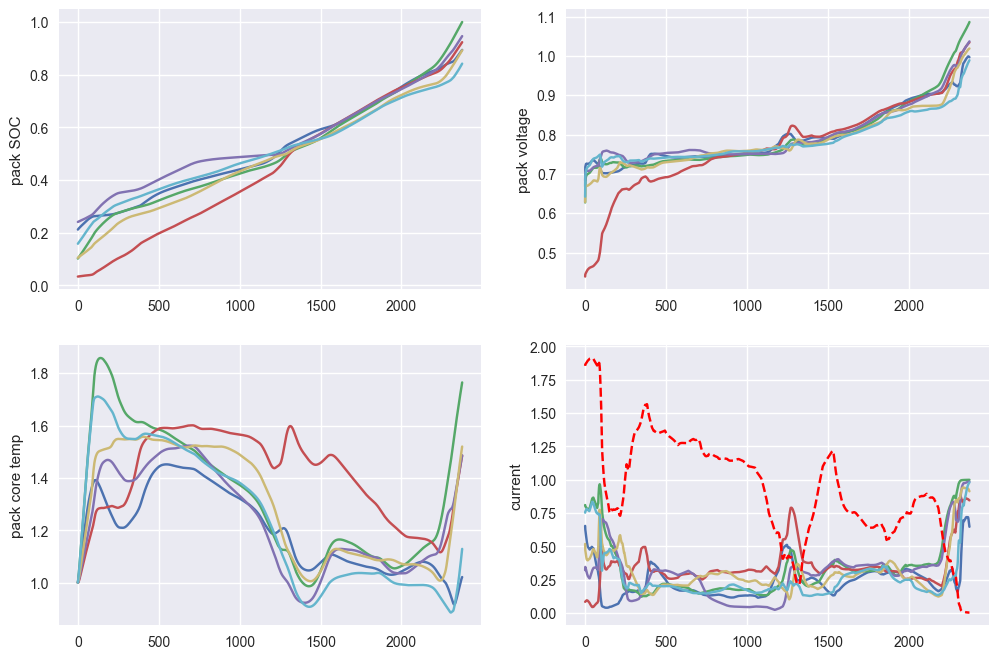

In [16]:
vec_env = model.get_env()
state = vec_env.reset()

pack_res=[]
rewards = []
actions = []

done = False
pack_res.append(state.reshape(3,6))
while not done:
    action, _states = model.predict(state, deterministic=True)
    next_state, reward, done, info = vec_env.step(action)
    state = next_state
    pack_res.append(next_state.reshape(3,6))
    rewards.append(reward)
    actions.append(action)

pack_res = np.array(pack_res)
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.plot(pack_res[:-1,0,:])
plt.ylabel('pack SOC')
plt.grid('on')
plt.subplot(2,2,2)
plt.plot(pack_res[:-1,1,:])
plt.ylabel('pack voltage')
plt.grid('on')
plt.subplot(2,2,3)
plt.plot(pack_res[:-1,2,:])
plt.ylabel('pack core temp')
plt.grid('on')
plt.subplot(2,2,4)
plt.plot(np.array(actions)[:-1].reshape(-1,6+1)[:,:-1])
plt.plot(np.array(actions)[:-1].reshape(-1,6+1)[:,-1], "--", color='red')
plt.ylabel('current')
plt.grid('on')

In [12]:
np.array(actions)[:-1].shape

(826, 1, 2, 6)

(0.0, 0.2)

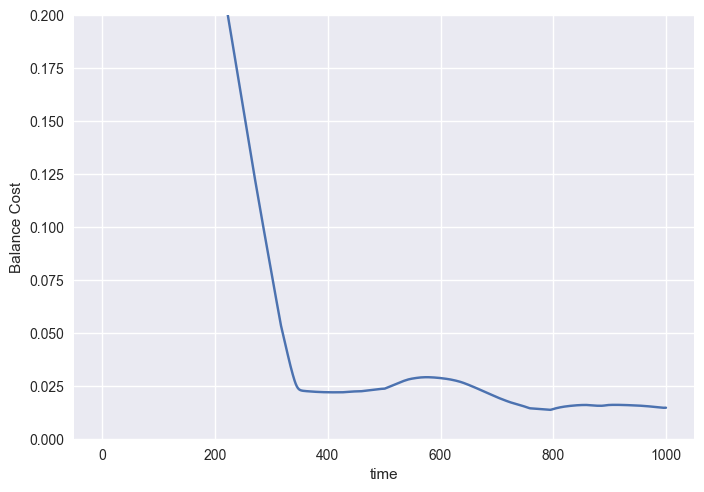

In [ ]:
plt.plot(np.abs(pack_res[:-1,0,:] - np.mean(pack_res[:-1,0,:], axis=-1).reshape(-1,1)).sum(-1))
plt.xlabel('time')
plt.ylabel('Balance Cost')
plt.grid('on')
plt.ylim([0,0.2])

(0.0, 0.2)

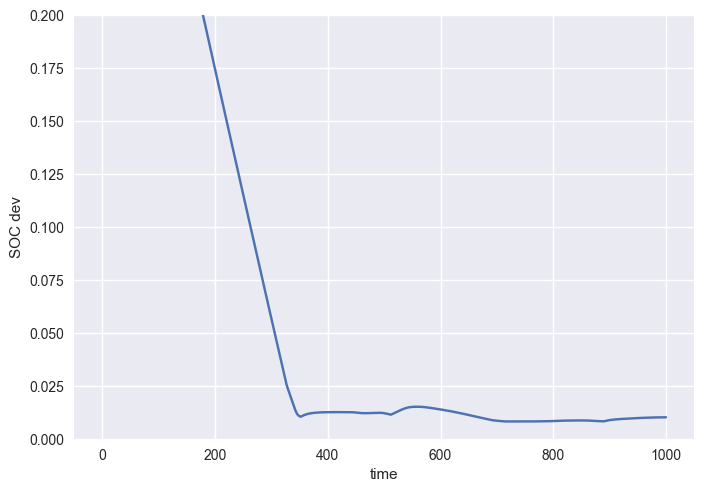

In [ ]:
plt.plot(pack_res[:-1,0,:].max(-1) - pack_res[:-1,0,:].min(-1))
plt.xlabel('time')
plt.ylabel('SOC dev')
plt.grid('on')
plt.ylim([0,0.2])

In [ ]:
np.abs(pack_res[:-1,0,:] - np.mean(pack_res[:-1,0,:], axis=-1).reshape(-1,1))

array([[0.0561325 , 0.00727535, 0.0779742 , 0.02047513, 0.01824863,
        0.02415743],
       [0.05587129, 0.00698174, 0.07704993, 0.02061593, 0.01787966,
        0.02429871],
       [0.05558156, 0.00669415, 0.07614671, 0.02084594, 0.01749014,
        0.02446504],
       ...,
       [0.01224321, 0.00827712, 0.01319575, 0.00377899, 0.00680345,
        0.00430018],
       [0.01249295, 0.00848955, 0.01322079, 0.00383258, 0.00701922,
        0.00457484],
       [0.01274639, 0.00870323, 0.01324058, 0.00388741, 0.00723839,
        0.00485837]], dtype=float32)

In [ ]:
np.mean(pack_res[:-1,0,:])

0.55164075

In [ ]:
pack_res[-2,0,:], np.std(pack_res[-2,0,:])

(array([0.9843846 , 0.98210174, 0.99976325, 0.9606002 , 0.9776403 ,
        0.9692358 ], dtype=float32),
 0.012284518)

In [ ]:
model.save('./last_model.pth')

# Tianshu

In [ ]:
pip install tianshou

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.7/162.7 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 65.2 MB/s eta 0:00:00
  Using cached Farama_Notifications-0.0.4-py3-none-any.whl (2.5 kB)


In [ ]:
import gymnasium as gym
import torch, numpy as np, torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import tianshou as ts

/usr/local/lib/python3.10/dist-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(


In [ ]:
lr, epoch, batch_size = 1e-3, 10, 64
train_num, test_num = 10, 100
gamma, n_step, target_freq = 0.9, 3, 320
buffer_size = 20000
eps_train, eps_test = 0.1, 0.05
step_per_epoch, step_per_collect = 10000, 10
logger = ts.utils.TensorboardLogger(SummaryWriter('log/dqn'))  # TensorBoard is supported!
# For other loggers: https://tianshou.readthedocs.io/en/master/tutorials/logger.html

In [ ]:
# you can also try with SubprocVectorEnv
train_envs = ts.env.DummyVectorEnv([lambda: LIBPackEnv('./LIBEnv/PANmodel.mat', number_of_cells=6, T=25, dt=1) for _ in range(train_num)])
test_envs = ts.env.DummyVectorEnv([lambda: LIBPackEnv('./LIBEnv/PANmodel.mat', number_of_cells=6, T=25, dt=1) for _ in range(test_num)])

/usr/local/lib/python3.10/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


TypeError: ignored

In [ ]:
isinstance(LIBPackEnv('./LIBEnv/PANmodel.mat', number_of_cells=6, T=25, dt=1), gym.Env)

False

In [ ]:
LIBPackEnv('./LIBEnv/PANmodel.mat', number_of_cells=6, T=25, dt=1).dtype

AttributeError: ignored

In [ ]:
import os

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

from stable_baselines3 import TD3
from stable_baselines3.common import results_plotter
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy, plot_results
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback


class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq:
    :param log_dir: Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: Verbosity level: 0 for no output, 1 for info messages, 2 for debug messages
    """
    def __init__(self, check_freq: int, log_dir: str, verbose: int = 1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

          # Retrieve training reward
          x, y = ts2xy(load_results(self.log_dir), "timesteps")
          if len(x) > 0:
              # Mean training reward over the last 100 episodes
              mean_reward = np.mean(y[-100:])
              if self.verbose >= 1:
                print(f"Num timesteps: {self.num_timesteps}")
                print(f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}")

              # New best model, you could save the agent here
              if mean_reward > self.best_mean_reward:
                  self.best_mean_reward = mean_reward
                  # Example for saving best model
                  if self.verbose >= 1:
                    print(f"Saving new best model to {self.save_path}")
                  self.model.save(self.save_path)

        return True

# Create log dir
log_dir = "tmp/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env = gym.make("LunarLanderContinuous-v2")
env = Monitor(env, log_dir)

# Add some action noise for exploration
n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
# Because we use parameter noise, we should use a MlpPolicy with layer normalization
model = TD3("MlpPolicy", env, action_noise=action_noise, verbose=0)
# Create the callback: check every 1000 steps
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)
# Train the agent
timesteps = 1e5
model.learn(total_timesteps=int(timesteps), callback=callback)

plot_results([log_dir], timesteps, results_plotter.X_TIMESTEPS, "TD3 LunarLander")
plt.show()